1.	Analyse globale du DataSet

In [63]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
#Chargement des données 
Data = pd.read_csv('../../data/Airbnb prediction.csv', delimiter=',')

In [64]:
#Nettoyage initial 
Data.drop(columns=['id','description', 'first_review', 'host_has_profile_pic', 
                   'host_identity_verified',  'host_response_rate', 'host_since', 
                   'last_review', 'latitude', 'longitude', 'name','number_of_reviews',
                   'review_scores_rating', 'thumbnail_url', 'zipcode'], inplace=True)
#Exploration du jeu de données 
print(f"Taille du dataSet : {Data.shape}")
Data.dtypes.value_counts()

Taille du dataSet : (74111, 14)


object     8
float64    4
int64      1
bool       1
Name: count, dtype: int64

In [65]:
#Gestion des doublons
print(f"Nombre de doubloms : {Data[Data.duplicated()==True].shape[0]}")
Data.drop_duplicates(inplace=True)

Nombre de doubloms : 269


In [66]:
#Analyse des valeurs manquantes 
df=pd.DataFrame(Data.isna().sum(), columns=['total'])
df[df['total']>0].sort_values(['total'], ascending=False)

,total
neighbourhood,6826
bathrooms,199
beds,131
bedrooms,90


2.	Analyse de la target

<Axes: xlabel='log_price', ylabel='Count'>

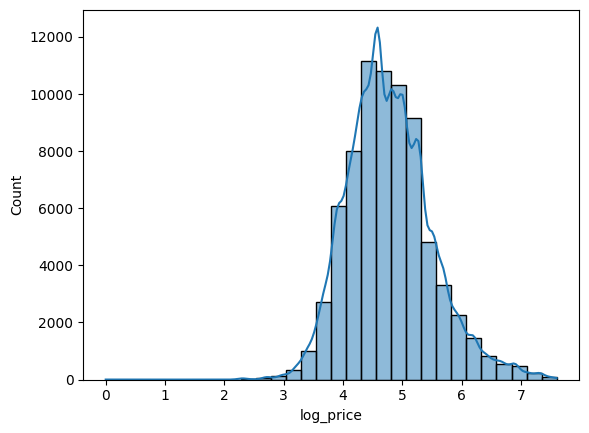

In [67]:
#Distribution des prix 
sns.histplot(data=Data, x='log_price', bins=30, kde=True)

<Axes: xlabel='price', ylabel='Count'>

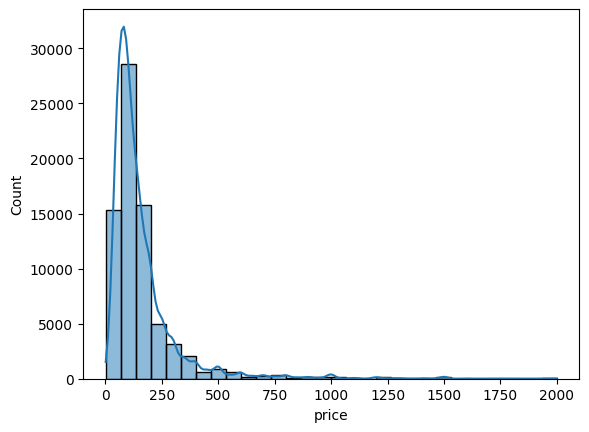

In [68]:
#Comparaison avec les prix réels 
Data['price']=Data['log_price'].apply(lambda x : math.exp(x))
sns.histplot(data=Data, x='price', bins=30, kde=True)

In [69]:
#Transformation de la target 
Data.drop(columns=['log_price'], inplace=True)

In [70]:
#Nettoyage des valeurs extrêmes 
Data=Data[Data.price>10]
print(f"Nombre de locations supérieures à 1000$ : {Data[Data['price']>1000].shape[0]}")

Nombre de locations supérieures à 1000$ : 668


In [71]:
#Comparaison des moyennes > 1000$
Data[(Data['price']>1000)].select_dtypes(exclude=['object']).mean()

accommodates       7.287425
bathrooms          2.723388
cleaning_fee       0.550898
bedrooms           2.950599
beds               3.642216
price           1289.420659
dtype: float64

In [72]:
#Comparaison des moyennes < 200$
Data[(Data['price']<200)].select_dtypes(exclude=['object']).mean()

accommodates      2.645815
bathrooms         1.126584
cleaning_fee      0.722966
bedrooms          1.068956
beds              1.454146
price           103.493204
dtype: float64

3.	Analyse du type de propriété

In [73]:
#Exploration du type de propriété
print(f"Nombre de type de propriétés : {len(Data.property_type.unique())}")

Nombre de type de propriétés : 35


In [74]:
#Analyse descriptive 
df=Data.groupby('property_type')['price'].agg(count='count',mean='mean').sort_values(by='count')
df

,count,mean
property_type,,
Casa particular,1,80.000000
Parking Space,1,100.000000
Island,1,150.000000
Lighthouse,1,250.000000
Train,2,182.500000
Cave,2,136.000000
Tipi,3,232.333333
Earth House,4,356.250000
Chalet,6,127.833333


In [75]:
#Réduction du nombre de catégories 
Lmoins50=list(df[df['count']<50].index)
Lplus50=list(df[df['count']>50].index)

In [76]:
import spacy
from spacy.cli import download
from spacy.util import is_package

primary_model = "en_core_web_md"
fallback_model = "en_core_web_sm"

try:
    nlp = spacy.load(primary_model)
except OSError:
    if not is_package(primary_model):
        download(primary_model)
    try:
        nlp = spacy.load(primary_model)
    except OSError:
        if not is_package(fallback_model):
            download(fallback_model)
        nlp = spacy.load(fallback_model)

In [77]:
#Calcul de la similarité des types rares :
similarities = {}
for target in Lmoins50 :
    sim = [(w, nlp(target).similarity(nlp(w))) for w in Lplus50]
    similarities[target]=sorted(sim, key=lambda x: x[1], reverse=True)[0]

In [78]:
for k, v in similarities.items():
    print(f"{k:<20} : {v[0]:<20}  {v[1]:.4f}")

Casa particular      : Villa                 0.2774
Parking Space        : Bungalow              0.6063
Island               : Camper/RV             0.5516
Lighthouse           : Camper/RV             0.5538
Train                : Bungalow              0.3961
Cave                 : Other                 0.3170
Tipi                 : Villa                 0.1505
Earth House          : House                 0.7629
Chalet               : Boutique hotel        0.2368
Treehouse            : Camper/RV             0.3941
Hut                  : Boat                  0.3326
Yurt                 : Villa                 0.1543
Vacation home        : Townhouse             0.5971
Castle               : Other                 0.3170
Tent                 : Boat                  0.3326
Serviced apartment   : Townhouse             0.7900


In [79]:
#Transformation des types rares 
Data.property_type=Data.property_type.apply( lambda x: similarities[x][0] 
    if (x in similarities and similarities[x][1] > 0.5) else x)
Data.property_type.value_counts()

property_type
Apartment          48846
House              16444
Condominium         2651
Townhouse           1720
Loft                1242
Other                605
Guesthouse           497
Bed & Breakfast      454
Bungalow             367
Villa                177
Dorm                 135
Guest suite          122
Camper/RV             96
Timeshare             77
Cabin                 72
In-law                71
Boutique hotel        68
Boat                  64
Hostel                63
Tent                  18
Castle                13
Yurt                   9
Hut                    8
Treehouse              7
Chalet                 6
Tipi                   3
Train                  2
Cave                   2
Casa particular        1
Name: count, dtype: int64

In [80]:
Data=Data[Data['property_type'].isin(Lplus50)] 

In [81]:
#Détection des outliers 
outliers={}
for type_pro in Data.property_type.unique():
    Q3=Data[Data.property_type==type_pro]['price'].quantile(0.75)
    Q1=Data[Data.property_type==type_pro]['price'].quantile(0.25)
    outliers[type_pro]=(Q3+3*(Q3-Q1), Data[Data.property_type==type_pro]['price'].mean())
for v in sorted(outliers.items(), key=lambda x: x[1][0]):
    print(f'{v[0]:<20} {v[1][0]:<20.2f} {v[1][1]:.2f}')

Dorm                 133.00               51.71
Hostel               283.00               59.81
Guesthouse           320.00               125.43
In-law               322.50               135.93
Bungalow             330.00               135.29
Bed & Breakfast      332.00               117.08
Guest suite          358.25               128.66
Cabin                375.00               118.12
Camper/RV            418.75               134.03
Boutique hotel       469.00               223.28
Apartment            475.00               146.34
Townhouse            590.00               183.47
Other                643.00               212.73
House                650.00               188.86
Loft                 668.00               204.12
Condominium          730.00               204.90
Boat                 755.00               252.61
Timeshare            996.00               310.45
Villa                1423.00              385.77


In [82]:
#Nombre d'outliers par type de propriétés
pd.DataFrame((Data.groupby('property_type')['price'].apply(lambda x: (x > outliers[x.name][0])
    .sum()))).sort_values(by='price')

,price
property_type,
Cabin,0
In-law,0
Timeshare,0
Hostel,1
Guest suite,3
Camper/RV,3
Boutique hotel,4
Dorm,5
Boat,5


4.	Analyse des types de chambre

In [83]:
#Analyse des types de chambre 
df=Data.groupby('room_type')['price'].agg(count='count',mean='mean').sort_values(by='count')
df

,count,mean
room_type,,
Shared room,2111,64.492184
Private room,30487,88.483583
Entire home/apt,41173,218.763121


<Axes: xlabel='room_type', ylabel='price'>

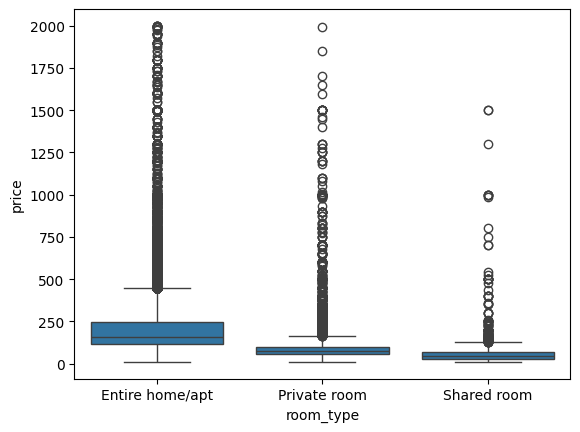

In [84]:
#Visualisation des distributions de prix 
sns.boxplot(data=Data, x='room_type', y='price')

<Axes: xlabel='price', ylabel='Count'>

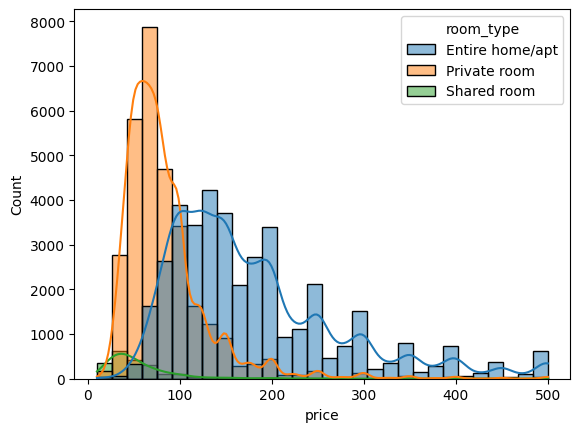

In [85]:
#Analyse de la variation des prix 
Dt=Data[Data['price']<500]
sns.histplot(data=Dt, x='price', kde=True, hue='room_type', bins=30)

5.	Analyse de la feature accomodates

In [86]:
#Exploration des valeurs possibles 
df=Data.groupby('accommodates')['price'].agg(count='count',mean='mean').sort_values(by='mean')
df

,count,mean
accommodates,,
1,9388,80.487963
2,31711,112.193876
3,7753,143.471430
4,12024,190.243513
5,3422,233.791058
6,4953,292.012518
7,941,312.937301
9,268,360.977612
13,36,392.611111


In [87]:
#Préparation des données  
sc = MinMaxScaler()
Data.accommodates=sc.fit_transform(Data[['accommodates']])

6.	Analyse de la feature bathrooms

In [88]:
#Influence entre le nombre de salles de bains et le prix 
df=Data.groupby('bathrooms')['price'].agg(count='count',mean='mean').sort_values(by='mean')
df

,count,mean
bathrooms,,
0.5,207,92.628019
0.0,192,100.359375
1.0,57874,131.117341
1.5,3791,165.176207
2.0,7878,247.511043
2.5,1561,357.121076
3.0,1049,385.215443
8.0,38,445.763158
4.0,276,518.713768


In [89]:
#Analyse croisée avec le type de chambre 
Dt=Data[Data.bathrooms==8.0]
Dt.groupby(['room_type'])['price'].mean()

room_type
Entire home/apt    1558.000000
Private room         88.800000
Shared room          39.782609
Name: price, dtype: float64

In [90]:
#Traitement des valeurs manquantes 
prixMoyen=Data[Data.bathrooms.isna()]['price'].mean()
print(f'Prix moyen des valeurs manquantes : {prixMoyen}')
Data.bathrooms=Data.bathrooms.fillna(value=1)

Prix moyen des valeurs manquantes : 130.4924623115578


In [91]:
#Normalisation 
Data.bathrooms=sc.fit_transform(Data[['bathrooms']])

7.	Analyse de la feature bed_type

In [92]:
#Analyse des types de lit 
df=Data.groupby('bed_type')['price'].agg(count='count',mean='mean').sort_values(by='mean')
df

,count,mean
bed_type,,
Futon,751,92.918775
Pull-out Sofa,584,102.722603
Airbed,471,109.263270
Couch,268,111.100746
Real Bed,71697,162.208544


In [93]:
#Regroupement en deux catégories 
Data.bed_type=Data.bed_type.apply(lambda x : 1 if x=='Real Bed' else 0) 	 

8.	Analyse de la cancelation_policy

In [94]:
#Analyse des politiques d'annulation 
df=Data.groupby('cancellation_policy')['price'].agg(count='count',mean='mean').sort_values(by='mean')
df

,count,mean
cancellation_policy,,
moderate,18996,141.554380
flexible,22471,150.435539
strict,32175,177.966900
super_strict_30,112,264.205357
super_strict_60,17,929.176471


In [95]:
#Transformation des données 
Cancelation=list(df.index)
Data.cancellation_policy=Data.cancellation_policy.apply(lambda x : Cancelation.index(x))
Data.cancellation_policy.value_counts()

cancellation_policy
2    32175
1    22471
0    18996
3      112
4       17
Name: count, dtype: int64

In [96]:
#Normalisation 
Data.cancellation_policy=sc.fit_transform(Data[['cancellation_policy']])

9.	Analyse des features cleaning_fee et instant_bookable

<Axes: xlabel='price', ylabel='Count'>

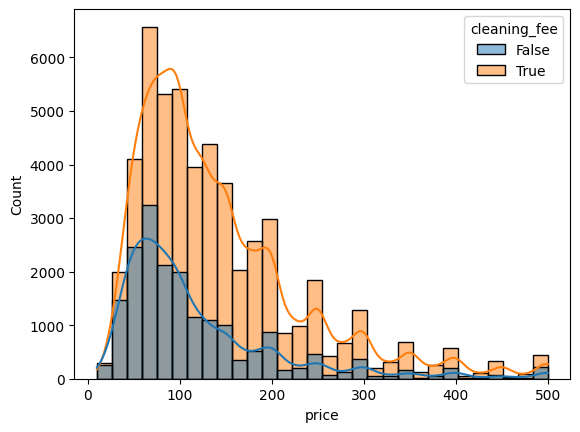

In [97]:
#Exploration de cleaning_fee 
Dt=Data[Data['price']<500]
sns.histplot(data=Dt, x='price', kde=True, bins=30, hue='cleaning_fee') 

In [98]:
#Suppression de la feature 
Data.drop(columns=['cleaning_fee'], inplace=True)

<Axes: xlabel='price', ylabel='Count'>

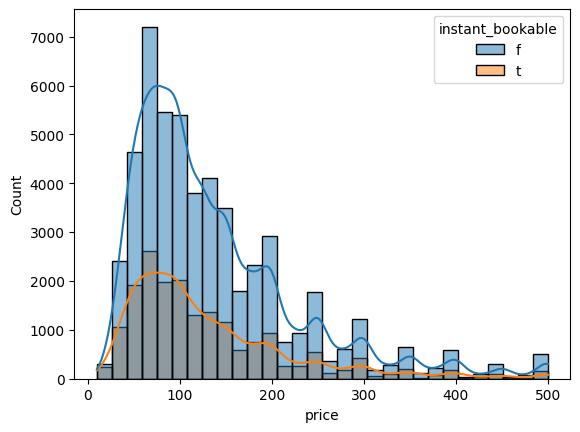

In [99]:
#Exploration de instant_bookable 
Dt=Data[Data['price']<500]
sns.histplot(data=Dt, x='price', kde=True, bins=30, hue='instant_bookable') 

In [100]:
#Suppression de la feature 
Data.drop(columns=['instant_bookable'], inplace=True)

10.	Analyse de la variable bedrooms

In [101]:
#Prix moyen par nombre de lits  
df=Data.groupby('bedrooms')['price'].agg(count='count',mean='mean').sort_values(by='mean')
df

,count,mean
bedrooms,,
1.0,49535,114.926012
0.0,6684,143.992968
2.0,11308,233.518217
3.0,4298,349.833644
4.0,1326,498.949472
5.0,355,629.200000
6.0,105,805.857143
9.0,8,807.375000
10.0,10,824.000000


In [102]:
#Analyse des valeurs manquantes 
prixMoyen=Data[Data.bedrooms.isna()]['price'].mean()
print(f'Nombre de valeurs manquantes : {Data[Data.bedrooms.isna()==True].shape[0]} - prix moyen {prixMoyen:.4f}')

Nombre de valeurs manquantes : 90 - prix moyen 133.7556


In [103]:
#Traitement des valeurs aberrantes 
Data.bedrooms=Data.bedrooms.apply(lambda x : 1 if x==0 else x)
Data[Data.bedrooms.isna()]['property_type'].value_counts()

property_type
Apartment      73
House           9
Loft            3
Other           2
Villa           1
Bungalow        1
Condominium     1
Name: count, dtype: int64

In [104]:
#Imputation des valeurs manquantes 
Data.bedrooms=Data.bedrooms.fillna(value=1)
#Normalisation 
Data.bedrooms=sc.fit_transform(Data[['bedrooms']])

11.	Analyse de la variable beds

In [105]:
#Analyse des valeurs manquantes 
prixMoyen=Data[Data.beds.isna()]['price'].mean()
print(f'Nombre de valeurs manquantes : {Data[Data.beds.isna()==True].shape[0]} - prix moyen {prixMoyen:.4f}')

Nombre de valeurs manquantes : 131 - prix moyen 124.7481


In [106]:
#Prix moyen par nombre de lits 
df=Data.groupby('beds')['price'].agg(count='count',mean='mean').sort_values(by='mean')
df

,count,mean
beds,,
1.0,44933,112.720985
2.0,16632,182.980640
0.0,4,250.750000
3.0,6423,258.285069
4.0,3050,320.470492
8.0,180,371.861111
5.0,1283,393.697584
6.0,656,413.400915
7.0,214,459.387850


In [107]:
#Imputation des valeurs manquantes 
Data.beds=Data.beds.fillna(value=1)
#Normalisation 
Data.beds=sc.fit_transform(Data[['beds']])

12.	Analyse de la variable city

In [108]:
#Répartition par ville 
df=Data.groupby('city')['price'].agg(count='count',mean='mean').sort_values(by='mean')
df

,count,mean
city,,
Chicago,3703,132.644883
NYC,32269,143.157891
LA,22299,155.705816
Boston,3421,164.635194
DC,5667,218.049409
SF,6412,227.564410


<Axes: xlabel='price', ylabel='Count'>

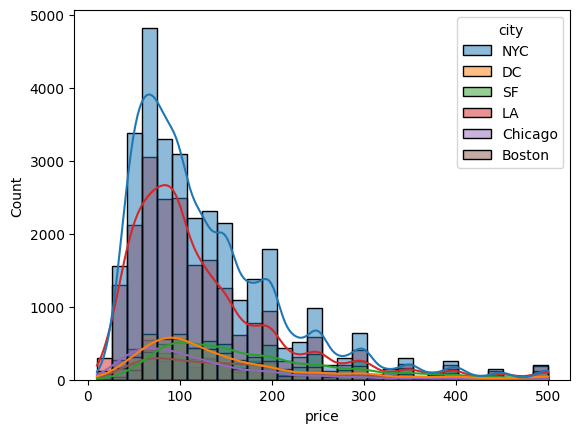

In [109]:
#Analyse détaillée 
df=Data[Data['price']<500]
sns.histplot(data=df, x='price', kde=True, bins=30, hue='city') 

13.	Influence des features

In [110]:
DataCopie = Data.copy()
#Transformation des données : Type de propriété
Data = pd.get_dummies(data=Data, columns= ['property_type'], drop_first=True, prefix_sep='',prefix='')
#Transformation des données : Type de chambre
Data = pd.get_dummies(data=Data, columns= ['room_type'], prefix_sep='',prefix='')
Data.drop(columns=['Shared room'], inplace=True)
#Transformation des données : City
Data = pd.get_dummies(data=Data, columns= ['city'], drop_first=True, prefix_sep='',prefix='')
Data.columns

Index(['amenities', 'accommodates', 'bathrooms', 'bed_type',
       'cancellation_policy', 'neighbourhood', 'bedrooms', 'beds', 'price',
       'Bed & Breakfast', 'Boat', 'Boutique hotel', 'Bungalow', 'Cabin',
       'Camper/RV', 'Condominium', 'Dorm', 'Guest suite', 'Guesthouse',
       'Hostel', 'House', 'In-law', 'Loft', 'Other', 'Timeshare', 'Townhouse',
       'Villa', 'Entire home/apt', 'Private room', 'Chicago', 'DC', 'LA',
       'NYC', 'SF'],
      dtype='object')

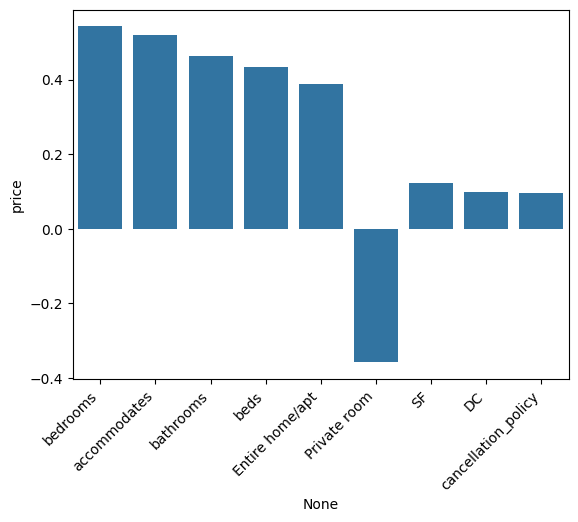

In [111]:
#Calcul des corrélations 
df=pd.DataFrame(Data.drop(['amenities','neighbourhood'], axis=1).corr()['price'])
df=df.sort_values(by='price', key=abs, ascending=False)[1:10]
sns.barplot(data=df, x=df.index, y='price')
plt.xticks(rotation=45, ha='right') 
plt.show()

14.	Traitement des quartiers

In [112]:
#Identification des quartiers 
print(f'Nombre de quartiers différents : {len(Data.neighbourhood.unique())}')

Nombre de quartiers différents : 620


<Axes: xlabel='price', ylabel='Count'>

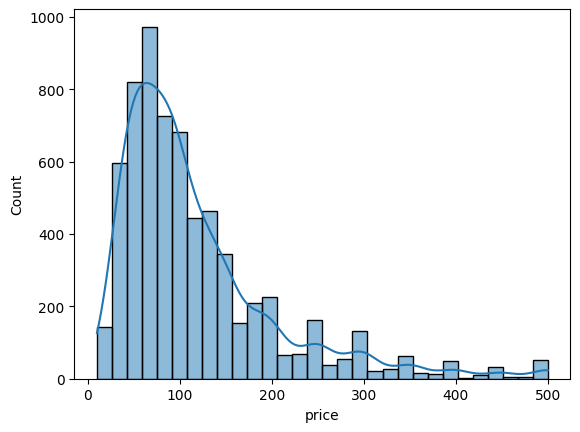

In [113]:
#Étude des valeurs manquantes 
df=Data[(Data.neighbourhood.isna()==True) & (Data['price']<500)]
sns.histplot(data=df, x='price', bins=30, kde=True)

<Axes: xlabel='price', ylabel='Count'>

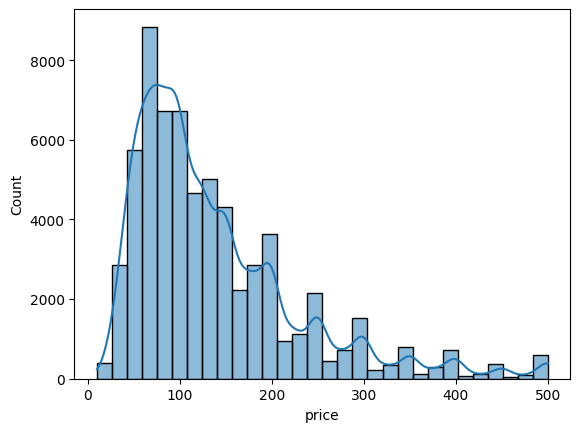

In [114]:
#Variantion prix moyens 
df=Data[(Data.neighbourhood.isna()!=True) & (Data['price']<500)]
sns.histplot(data=df, x='price', bins=30, kde=True)

In [115]:
#Nettoyage des données 
Data.dropna(subset=['neighbourhood'],axis=0, inplace=True)

In [116]:
#Regroupement des quartiers par tranches de prix 
df=Data.groupby('neighbourhood')['price'].agg(count='count',mean='mean').sort_values(by='mean')
#Découpage en bacs
df['Categorie'] = pd.cut(df['mean'], bins=50, labels=False)
df['Categorie'].value_counts()

Categorie
2     116
3      98
1      84
4      67
5      48
6      46
7      43
8      30
0      24
9      14
10     12
11      9
13      8
12      7
19      2
17      2
25      2
14      1
15      1
18      1
30      1
31      1
48      1
49      1
Name: count, dtype: int64

In [117]:
#Regroupement de bacs 
df['Categorie']=df['Categorie'].apply(lambda x : x if x<10 else 10)
df['Categorie'].value_counts()

Categorie
2     116
3      98
1      84
4      67
10     49
5      48
6      46
7      43
8      30
0      24
9      14
Name: count, dtype: int64

In [118]:
df

,count,mean,Categorie
neighbourhood,,,
South Chicago,6,25.000000,0
West Elsdon,3,30.000000,0
West Lawn,4,36.250000,0
"Suitland-Silver Hill, MD",1,37.000000,0
Edison Park,1,40.000000,0
...,...,...,...
Bellevue,3,671.666667,10
Sea Cliff,5,797.000000,10
Observatory Circle,1,825.000000,10


In [119]:
#Transformation et normalisation 
Data['neighbourhood']=Data.neighbourhood.map(df['Categorie'])
#Normalisation 
Data.neighbourhood=sc.fit_transform(Data[['neighbourhood']])

In [125]:
Data.iloc[0].amenities

'{"Wireless Internet","Air conditioning",Kitchen,Heating,"Family/kid friendly",Essentials,"Hair dryer",Iron,"translation missing: en.hosting_amenity_50"}'

In [136]:
import re

Data.amenities = Data.amenities.apply(lambda x: re.sub(r'[\{\}\"]', '', x))

In [147]:
to_replace_ = [
    'Doorman Entry',
    'Elevator in building',
    'Internet',
    'Firm matress',
    'Other pet(s)',
    'Smart lock',
    'Wide clearance to bed',
    'Wide clearance to shower & toilet',
    'Wide clearance to shower and toilet',
    'translation missing: en.hosting_amenity_49',
    'translation missing: en.hosting_amenity_50',
    'Waterfront'
]

replace_ = [
    'Doorman',
    'Elevator',
    'Ethernet connection',
    'Firm mattress',
    'Pets allowed',
    'Smartlock',
    'Wide clearance',
    'Wide clearance',
    'Wide clearance',
    'translation missing',
    'translation missing',
    'Beachfront'
]

Data.amenities = Data.amenities.replace(to_replace=to_replace_, value=replace_,  regex=True)
Data.amenities

0        Wireless Ethernet connection,Air conditioning,...
1        Wireless Ethernet connection,Air conditioning,...
2        TV,Cable TV,Wireless Ethernet connection,Air c...
3        TV,Cable TV,Ethernet connection,Wireless Ether...
4        TV,Ethernet connection,Wireless Ethernet conne...
                               ...                        
74106                                                     
74107    TV,Cable TV,Ethernet connection,Wireless Ether...
74108    TV,Ethernet connection,Wireless Ethernet conne...
74109    TV,Wireless Ethernet connection,Air conditioni...
74110    TV,Ethernet connection,Wireless Ethernet conne...
Name: amenities, Length: 66962, dtype: object

In [148]:
ensemble_amenity = set(amenity.strip()
    for row in Data.amenities.dropna()
    for amenity in row.split(',')
    if amenity.strip()
    )

ensemble_amenity

{'24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Bath towel',
 'Bathtub',
 'Bathtub with shower chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Body soap',
 'Breakfast',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Cooking basics',
 'Crib',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Dryer',
 'EV charger',
 'Elevator',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Family/kid friendly',
 'Fire extinguisher',
 'Fireplace guards',
 'Firm mattress',
 'First aid kit',
 'Fixed grab bars for shower & toilet',
 'Flat',
 'Flat smooth pathway to front door',
 'Free parking on premises',
 'Free parking on street',

In [156]:
def encodage(df) :
    ensemble_amenity = set(amenity.strip()
        for row in df.amenities.dropna()
        for amenity in row.split(',')
        if amenity.strip()
        )
    for amenity in ensemble_amenity:
        dummies = pd.DataFrame([1 if amenity in s.split(',') else 0 for s in df['amenities']], columns=[amenity], index=df.index)
        df = pd.concat([df, dummies], axis=1)
    df.drop(columns=['amenities'], inplace=True)
    return df, ensemble_amenity

In [157]:
df, ensemble_amenity = encodage(Data)
print(df.shape)
pd.DataFrame(df.head())

(66962, 154)


,accommodates,bathrooms,bed_type,cancellation_policy,neighbourhood,bedrooms,beds,price,Bed & Breakfast,Boat,...,Self Check-In,Hangers,First aid kit,Window guards,Flat smooth pathway to front door,Bath towel,Iron,Table corner guards,Flat,Wide clearance
0,0.133333,0.125,1,0.50,0.6,0.000000,0.055556,150.0,False,False,...,0,0,0,0,0,0,1,0,0,0
1,0.400000,0.125,1,0.50,0.6,0.222222,0.166667,169.0,False,False,...,0,1,0,0,0,0,1,0,0,0
2,0.266667,0.125,1,0.00,0.3,0.000000,0.166667,145.0,False,False,...,0,1,0,0,0,0,1,0,0,0
3,0.200000,0.125,1,0.25,0.8,0.111111,0.111111,750.0,False,False,...,0,0,1,0,0,0,0,0,0,0
4,0.066667,0.125,1,0.00,0.6,0.000000,0.055556,115.0,False,False,...,0,0,0,0,0,0,0,0,0,0


In [229]:
#### df.to_csv('../../data/Airbnb_preprocessed.csv', index=False)

In [236]:
df = pd.read_csv('../../data/Airbnb_preprocessed.csv', delimiter=',')
df.shape

(66962, 131)

In [237]:
# Supprimer les colonnes en double :
df = df.loc[:, ~df.columns.duplicated()]
df.shape

(66962, 131)

In [238]:
amenities_to_drop = []
for amenity in ensemble_amenity:
    if amenity in df.columns and df[amenity].sum() < 100:
        amenities_to_drop.append(amenity)

df.drop(columns=amenities_to_drop, inplace=True)


In [239]:
from sklearn.feature_selection import f_regression

f, p = f_regression(df.drop(columns=['price']), df['price'])

In [240]:
dt = pd.DataFrame({'Feature': df.drop(columns=['price']).columns, 'F-value': f, 'p-value': p})
dt.sort_values(by='p-value', ascending=False)

,Feature,F-value,p-value
104,Firm mattress,0.001232,0.972002
74,Beachfront,0.007261,0.932093
88,Cleaning before checkout,0.032617,0.856681
68,Single level home,0.040218,0.841056
119,Beach essentials,0.052845,0.818186
...,...,...,...
80,Family/kid friendly,3217.653553,0.000000
107,Cable TV,2056.963299,0.000000
109,Dryer,1774.779641,0.000000
100,TV,2190.179756,0.000000


In [241]:
col_a_jeter = list(dt[dt['p-value']>0.05]["Feature"])
df.drop(columns=col_a_jeter, inplace=True)
df.shape

(66962, 101)

In [242]:
from sklearn.model_selection import train_test_split

In [244]:
y = df['price'].apply(lambda x: math.log(x))
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['price']), y, test_size=0.2, random_state=0)

In [245]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [246]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [247]:
model.score(X_test, y_test)

0.335735484818132

In [248]:
math.sqrt(mean_squared_error(y_test, y_pred))

0.5741065551054104

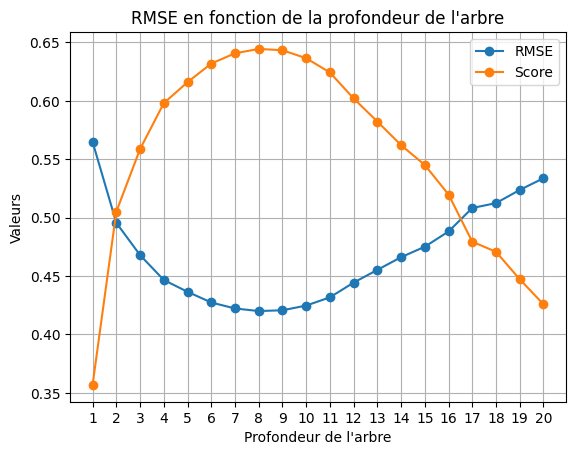

In [251]:
resultatsRMSE = []
resultatsScore = []

for depth in range(1, 21):
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    score = model.score(X_test, y_test)
    resultatsRMSE.append(rmse)
    resultatsScore.append(score)

plt.plot(range(1, 21), resultatsRMSE, marker='o', label='RMSE')
plt.plot(range(1, 21), resultatsScore, marker='o', label='Score')
plt.title("RMSE en fonction de la profondeur de l'arbre")
plt.xlabel("Profondeur de l'arbre")
plt.ylabel("Valeurs")
plt.xticks(range(1, 21))
plt.grid()
plt.legend()
plt.show()

In [252]:
pd.DataFrame(data=model.feature_importances_, index=X_train.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

,Importance
Entire home/apt,0.396306
bathrooms,0.134329
neighbourhood,0.118531
accommodates,0.034407
bedrooms,0.031056
...,...
Dorm,0.000063
Changing table,0.000059
Cabin,0.000055
Fireplace guards,0.000034
